## Import

In [19]:
import matplotlib.pyplot as plt
import numpy as np

from keras import Input, Model
from keras import activations
from keras.models import load_model
from keras.applications import ResNet50
from keras.layers import Dense, LeakyReLU, Dropout, Concatenate, Lambda
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from vis.utils import utils
from vis.utils.utils import find_layer_idx
from vis.visualization import visualize_saliency

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

Using TensorFlow backend.


In [20]:
!which jupyter

/opt/anaconda3/envs/quoc_py36/bin/jupyter


## Data

In [21]:
!which python

/opt/anaconda3/envs/quoc_py36/bin/python


In [22]:
batch_size = 10
epochs=50
best_weights = 'weights/best_model.h5'

In [23]:
width, height, depth = 200, 200, 3

train_generator = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=10,
    zoom_range=0.2,
    fill_mode='wrap',
    validation_split=0.2
)

train_datagen = train_generator.flow_from_directory(
    'data/train/',
    target_size = (width,height),
    class_mode = 'binary',
    batch_size = batch_size,
    subset = 'training',
)

val_datagen = train_generator.flow_from_directory(
    'data/train/',
    target_size = (width,height),
    class_mode = 'binary',
    batch_size = batch_size,
    subset = 'validation',
)

test_generator = ImageDataGenerator(
#     horizontal_flip=True,
#     vertical_flip=True,
#     rotation_range=10,
#     zoom_range=0.2,
#     fill_mode='wrap',
#     validation_split=0.2
)

test_datagen = test_generator.flow_from_directory(
    'data/test',
    target_size=(width, height),
    class_mode = 'binary',
    batch_size = 97,
    shuffle=False)

Found 327 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


## Model

In [24]:
inputs = Input(shape=[width, height, depth])
base_model = ResNet50(input_shape=inputs.shape[1:],
                      input_tensor=inputs,
                      include_top=False,
                      classes=1,
                      pooling='avg'
                      )
x = base_model.output
x = Dense(394)(x)
x = LeakyReLU()(x)
x = Dropout(0.1)(x)
x = Dense(1, activation='sigmoid', kernel_initializer='he_normal')(x)

model = Model(inputs, x)

# plot_model(model, 'single-image-model.png', show_shapes=True)

In [25]:
#plot_model(model, 'single-image-model.png', show_shapes=True)

In [26]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

In [27]:
# Optionally load model back
model.load_weights(best_weights)

In [10]:
for layer in base_model.layers: 
    layer.trainable = False

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

model.fit_generator(
    generator=train_datagen,
    steps_per_epoch=None,
    epochs=5,
    validation_data=val_datagen,
    callbacks=[
        EarlyStopping(monitor='val_loss',
                      patience=25,
                      verbose=1),
        ModelCheckpoint(best_weights,
                        save_best_only=True,
                        save_weights_only=False,
                        monitor='val_loss'),
    ])

Epoch 1/5
33/33 [==============================] - 4s 108ms/step - loss: 0.3457 - acc: 0.8586 - val_loss: 0.6864 - val_acc: 0.6250
Epoch 2/5
33/33 [==============================] - 2s 46ms/step - loss: 0.1028 - acc: 0.9727 - val_loss: 1.3898 - val_acc: 0.6250
Epoch 3/5
33/33 [==============================] - 2s 62ms/step - loss: 0.0418 - acc: 1.0000 - val_loss: 1.4362 - val_acc: 0.6250
Epoch 4/5
33/33 [==============================] - 2s 62ms/step - loss: 0.0564 - acc: 0.9818 - val_loss: 1.4710 - val_acc: 0.6250
Epoch 5/5
33/33 [==============================] - 2s 62ms/step - loss: 0.0684 - acc: 0.9697 - val_loss: 1.8620 - val_acc: 0.6250


In [11]:
# unfrezze resnet layers
for layer in base_model.layers:
    layer.trainable = True

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])
    
model.fit_generator(
    generator=train_datagen,
    steps_per_epoch=None,
    epochs=20,
    validation_data=val_datagen,
    callbacks=[
    #         EarlyStopping(monitor='val_loss',
    #                       patience=25,
    #                       verbose=1),
    ModelCheckpoint(best_weights,
                    save_best_only=True,
                    save_weights_only=False,
                    monitor='val_loss'),
])

Epoch 1/20
33/33 [==============================] - 10s 309ms/step - loss: 0.0427 - acc: 0.9848 - val_loss: 2.6201e-04 - val_acc: 1.0000
Epoch 2/20
33/33 [==============================] - 3s 95ms/step - loss: 0.0067 - acc: 0.9970 - val_loss: 3.2122e-05 - val_acc: 1.0000
Epoch 3/20
33/33 [==============================] - 3s 95ms/step - loss: 0.0039 - acc: 0.9970 - val_loss: 8.0677e-06 - val_acc: 1.0000
Epoch 4/20
33/33 [==============================] - 3s 95ms/step - loss: 4.1136e-05 - acc: 1.0000 - val_loss: 2.3389e-07 - val_acc: 1.0000
Epoch 5/20
33/33 [==============================] - 3s 95ms/step - loss: 0.0144 - acc: 0.9909 - val_loss: 7.8932e-05 - val_acc: 1.0000
Epoch 6/20
33/33 [==============================] - 3s 95ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 2.2004e-05 - val_acc: 1.0000
Epoch 7/20
33/33 [==============================] - 3s 96ms/step - loss: 7.5479e-04 - acc: 1.0000 - val_loss: 4.8311e-06 - val_acc: 1.0000
Epoch 8/20
33/33 [===========================

In [ ]:
# Opitionally continue training if needed
# model.load_weights('weights/best_val.h5')
model.fit_generator(
    generator=train_datagen,
    steps_per_epoch=None,
    epochs=10,
    validation_data=val_datagen,
    callbacks=[
            EarlyStopping(monitor='val_loss',
                          patience=25,
                          verbose=1),
    ModelCheckpoint(best_weights,
                    save_best_only=True,
                    save_weights_only=False,
                    monitor='val_loss'),
])

In [ ]:
model.save_weights('weights/best_val.h5')

In [ ]:
model.save_weights

## Predict

In [10]:
metrics = model.evaluate_generator(test_datagen)
for metric, metric_name in zip(metrics, model.metrics_names):
    print(f"{metric_name}: {metric}")

loss: 0.27756640315055847
acc: 0.9318181872367859


In [11]:
test_datagen.class_indices

{'0.OK': 0, '1.NG': 1}

In [12]:
preds = model.predict_generator(test_datagen)
print(f"Preds shape: {preds}")

Preds shape: [[2.08455276e-07]
 [5.14053511e-08]
 [3.92622823e-08]
 [4.69888342e-08]
 [1.43646275e-07]
 [1.14986038e-08]
 [1.67671772e-07]
 [7.88223247e-08]
 [3.17164002e-08]
 [1.43537690e-07]
 [6.03131056e-08]
 [1.08262824e-07]
 [1.70937724e-07]
 [6.29244354e-08]
 [1.79775981e-07]
 [1.04173537e-07]
 [2.21444111e-07]
 [2.06880216e-07]
 [2.81664171e-07]
 [1.96133545e-08]
 [9.92664754e-01]
 [6.87442347e-02]
 [9.92664754e-01]
 [9.99999762e-01]
 [9.99999762e-01]
 [9.99999642e-01]
 [9.99999642e-01]
 [9.99997973e-01]
 [9.99997973e-01]
 [9.99999881e-01]
 [9.99999881e-01]
 [1.00000000e+00]
 [9.99999762e-01]
 [9.99999762e-01]
 [9.99999881e-01]
 [9.99999881e-01]
 [1.00000000e+00]
 [1.00000000e+00]
 [9.99999881e-01]
 [9.99999881e-01]
 [9.99999642e-01]
 [9.99999642e-01]
 [9.99999881e-01]
 [9.91064459e-02]]


In [13]:
preds_bin = np.round(preds).flatten()
y_test = test_datagen.classes

In [14]:
preds_bin

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0.], dtype=float32)

## Metrics

In [15]:
print(f"y_test shape: {y_test.shape}, preds shape: {preds_bin.shape}")

y_test shape: (44,), preds shape: (44,)


In [16]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, preds_bin)
print(f"Confusion matrix:\n{cm}")

Confusion matrix:
[[21  2]
 [ 1 20]]


In [19]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, preds_bin)
print(f"F1 score: {f1}")

F1 score: 0.9302325581395349


In [20]:
from sklearn.metrics import average_precision_score
aps = average_precision_score(y_test, preds_bin)    
print(f"Average precision score: {aps}")

Average precision score: 0.8885281385281384


## Visualize

In [25]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 2, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds_bin == y_test)==is_correct)

In [26]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        print(ims[i].shape)
        plt.imshow(ims[i])

In [14]:
def plot_val_with_title(idxs, title):
    imgs = [X_test[x] for x in idxs]
    title_probs = [preds[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Pickup NG images

In [21]:
!pwa

/bin/sh: 1: pwa: not found


In [12]:
test_datagen = test_generator.flow_from_directory(
    'data/test',
    target_size=(width, height),
    class_mode = 'binary',
    batch_size = 40,
    shuffle=False)

Found 48 images belonging to 2 classes.


In [13]:
test_datagen.filenames

['0.OK/IMG_4125.JPG',
 '0.OK/IMG_5414.JPG',
 '0.OK/IMG_5861.JPG',
 '0.OK/IMG_8354.JPG',
 '0.OK/IMG_9319.JPG',
 '0.OK/IMG_9988\\0_100.jpg',
 '0.OK/IMG_9988\\10_100.jpg',
 '0.OK/IMG_9988\\11_100.jpg',
 '0.OK/IMG_9988\\12_100.jpg',
 '0.OK/IMG_9988\\13_100.jpg',
 '0.OK/IMG_9988\\14_100.jpg',
 '0.OK/IMG_9988\\15_100.jpg',
 '0.OK/IMG_9988\\16_100.jpg',
 '0.OK/IMG_9988\\17_100.jpg',
 '0.OK/IMG_9988\\18_100.jpg',
 '0.OK/IMG_9988\\19_100.jpg',
 '0.OK/IMG_9988\\1_100.jpg',
 '0.OK/IMG_9988\\2_100.jpg',
 '0.OK/IMG_9988\\3_100.jpg',
 '0.OK/IMG_9988\\4_100.jpg',
 '0.OK/IMG_9988\\5_100.jpg',
 '0.OK/IMG_9988\\6_100.jpg',
 '0.OK/IMG_9988\\7_100.jpg',
 '0.OK/IMG_9988\\8_100.jpg',
 '0.OK/IMG_9988\\9_100.jpg',
 '0.OK/new_apple.jpg',
 '0.OK/tao_xanh.jpg',
 '1.NG/IMG_9995\\106_100.jpg',
 '1.NG/IMG_9995\\106_101.jpg',
 '1.NG/IMG_9995\\107_100.jpg',
 '1.NG/IMG_9995\\107_101.jpg',
 '1.NG/IMG_9995\\108_100.jpg',
 '1.NG/IMG_9995\\108_101.jpg',
 '1.NG/IMG_9995\\109_100.jpg',
 '1.NG/IMG_9995\\109_101.jpg',
 '1.NG/

In [14]:
X_test, y_test = next(test_datagen)

In [15]:
preds = model.predict(X_test).flatten()

In [16]:
X_test.size

4800000

In [17]:
preds_bin = np.round(preds)

In [18]:
X_test = X_test.astype(np.int)

In [19]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 2, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds_bin == y_test)==is_correct)
def plots(ims, figsize=(200, 50), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        print(ims[i].shape)
        plt.imshow(ims[i])

def plot_val_with_title(idxs, title):
    imgs = [X_test[x] for x in idxs]
    title_probs = [preds[x] for x in idxs]
    print(title)
    return plots(imgs, rows=2, titles=title_probs, figsize=(20,12))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * preds[idxs])[:20]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == y_test)==is_correct) & (y_test == y), mult)

most incorrect NG
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)


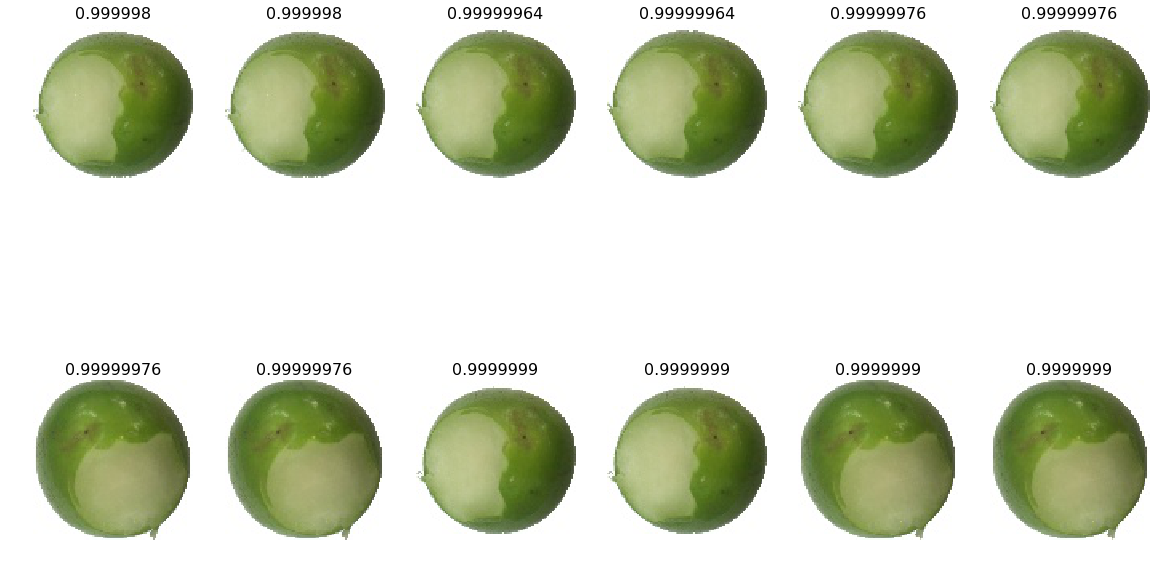

In [23]:
# plot_val_with_title(rand_by_correct(False), 'Predict wrong')
plot_val_with_title(most_by_correct(1, False), "most incorrect NG")


In [24]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, preds_bin)
print(f"Confusion matrix:\n{cm}")

Confusion matrix:
[[21  6]
 [ 0 13]]


In [27]:
# Draw Attention Map
layer_idx = find_layer_idx(model,'dense_1')
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

ground truth:  0.0
predict:  2.2144411e-07


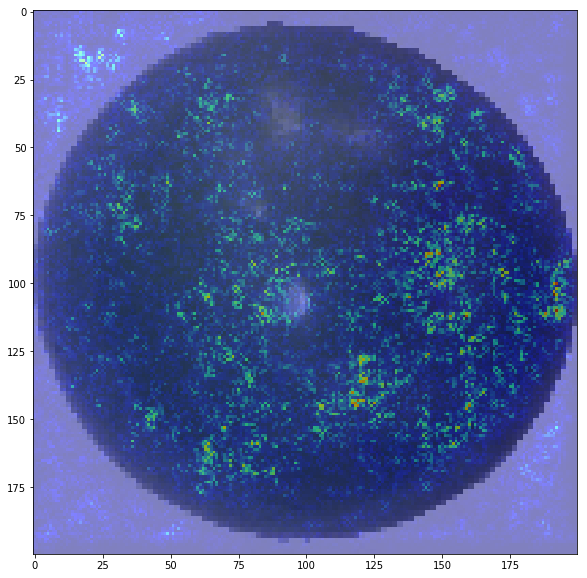

In [28]:
i = 21
plt.figure(figsize=(20, 10))
print("ground truth: ", y_test[i])
print("predict: ", preds[i])
grads = visualize_saliency(model, layer_idx, filter_indices=None, seed_input=X_test[i])
# plt.subplot(2, 2, 1)
plt.imshow(X_test[i])
plt.imshow(grads, cmap='jet', alpha=0.5)

ground truth:  0.0
predict:  0.9725221


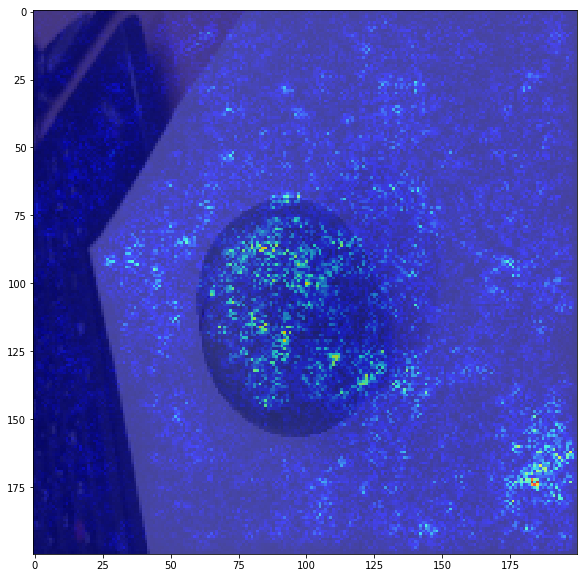

ground truth:  0.0
predict:  0.95061487


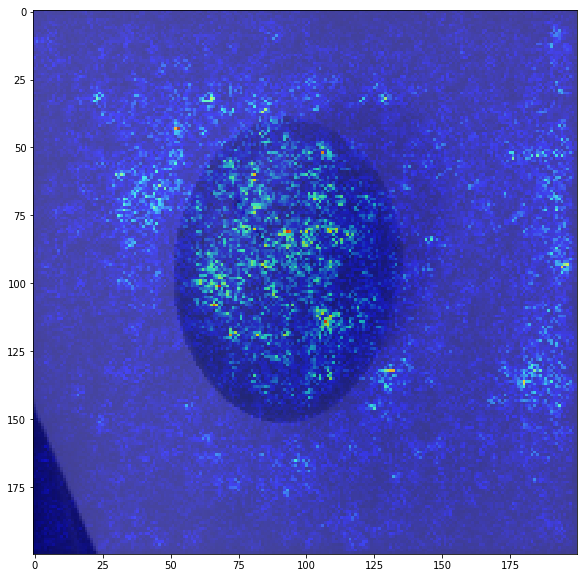

ground truth:  0.0
predict:  0.9842343


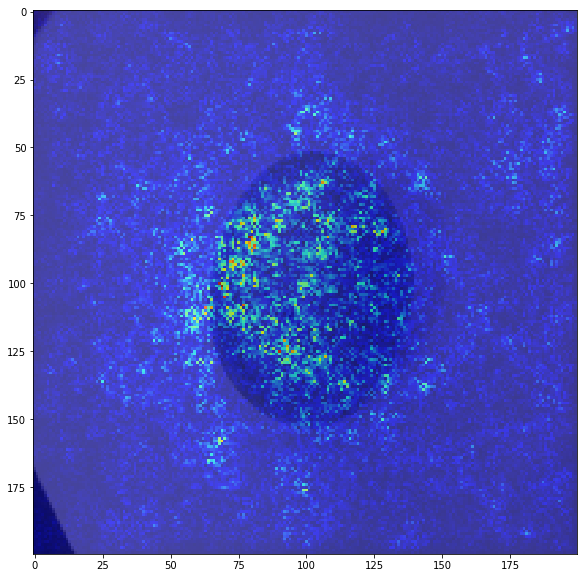

ground truth:  0.0
predict:  0.9943158


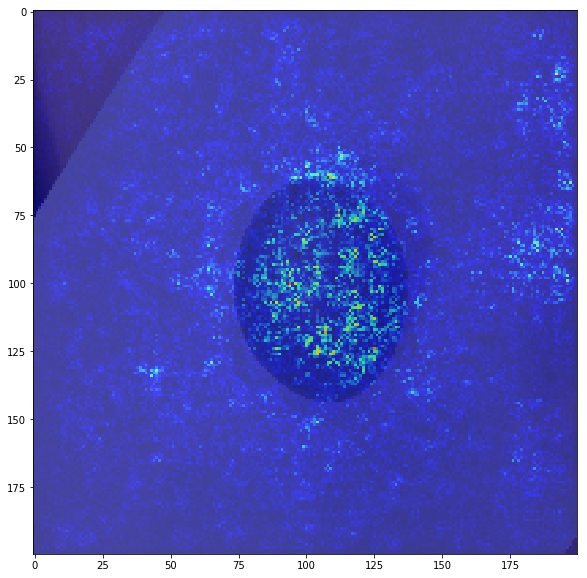

ground truth:  0.0
predict:  0.78075194


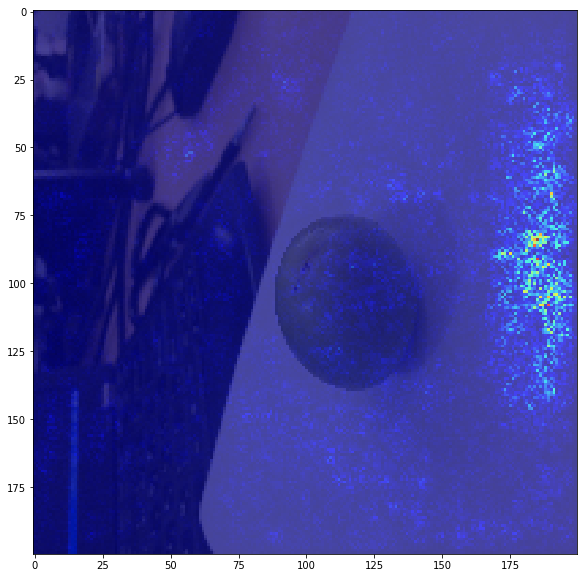

ground truth:  0.0
predict:  2.0845528e-07


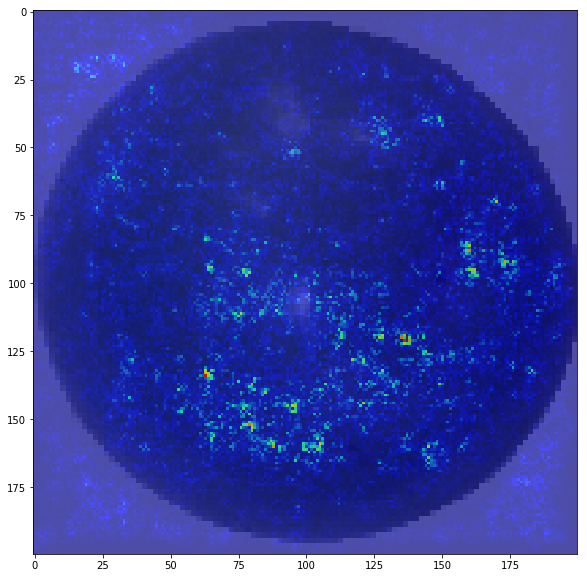

ground truth:  0.0
predict:  5.140535e-08


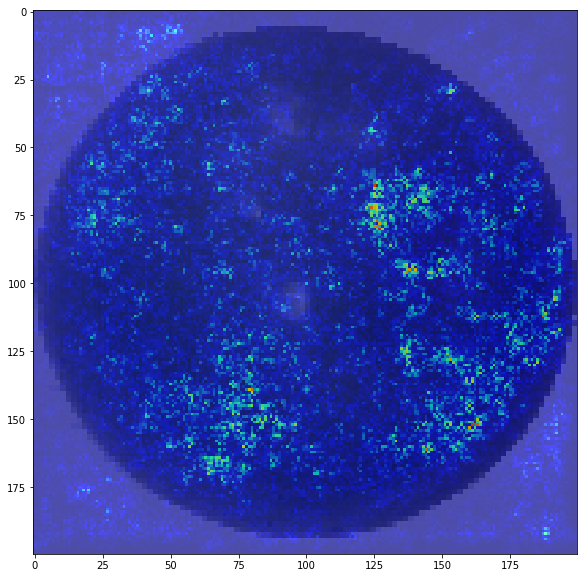

ground truth:  0.0
predict:  3.9262282e-08


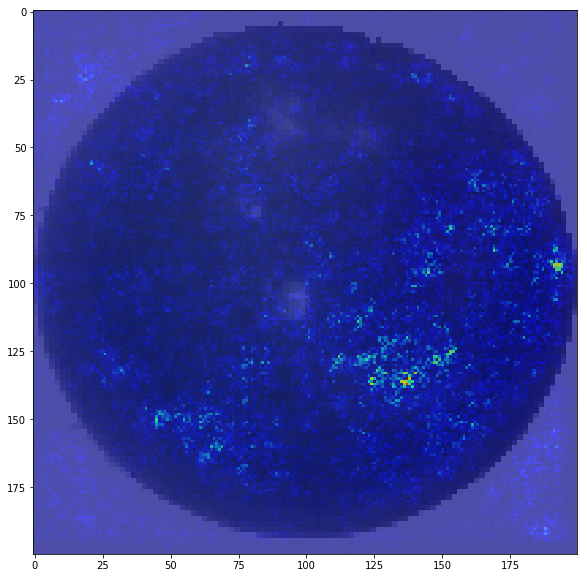

ground truth:  0.0
predict:  4.6988834e-08


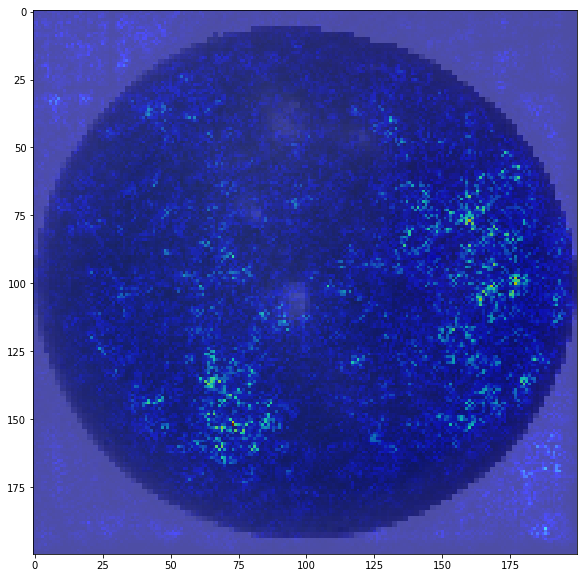

ground truth:  0.0
predict:  1.4364628e-07


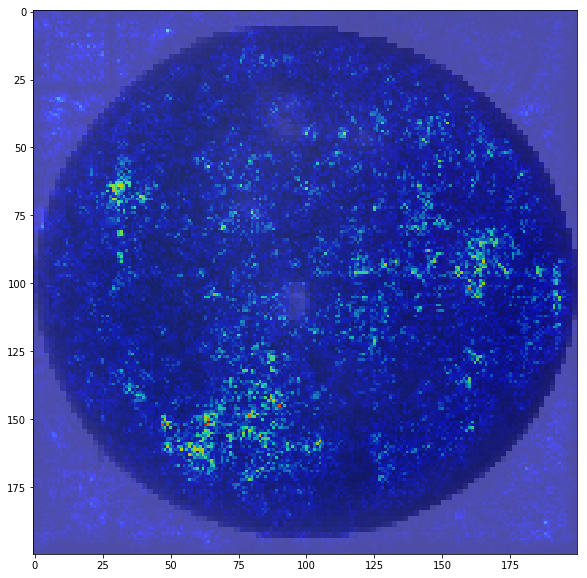

ground truth:  0.0
predict:  1.1498604e-08


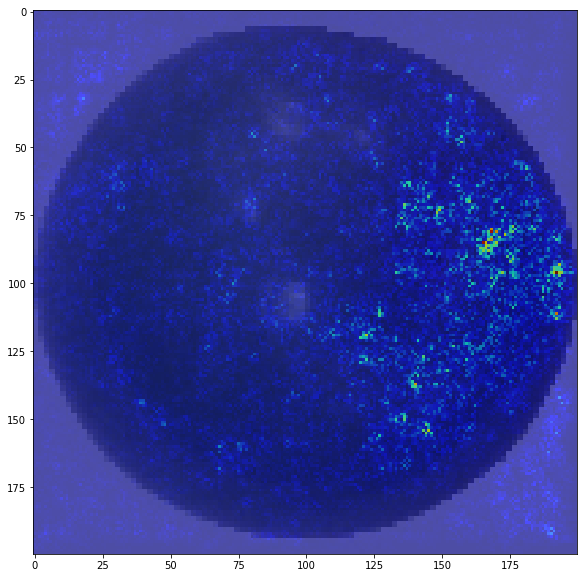

ground truth:  0.0
predict:  1.6767177e-07


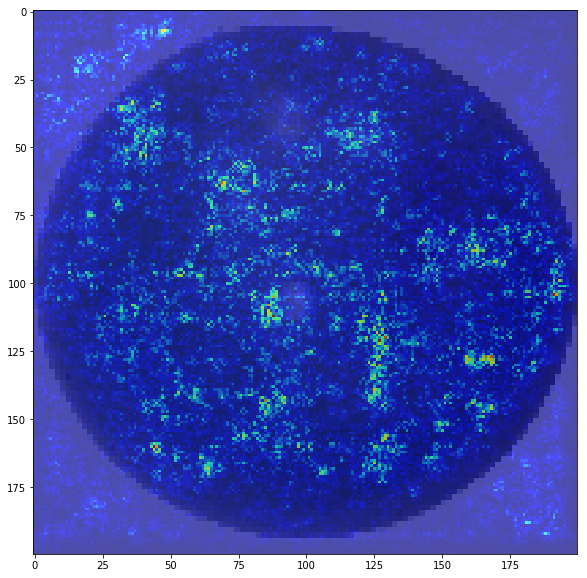

ground truth:  0.0
predict:  7.8822325e-08


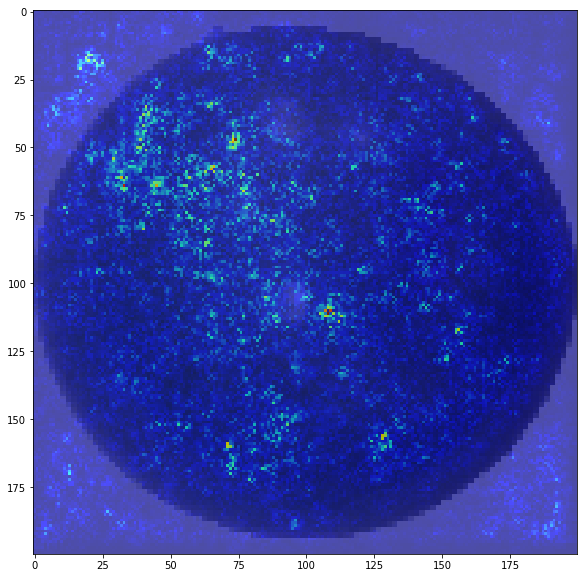

ground truth:  0.0
predict:  3.17164e-08


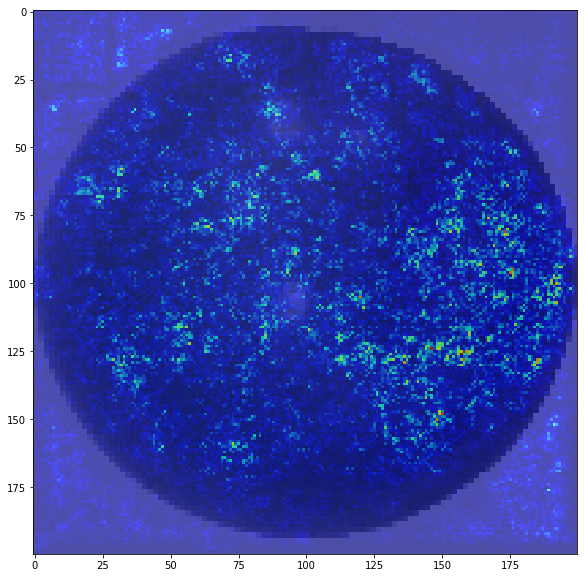

ground truth:  0.0
predict:  1.4353769e-07


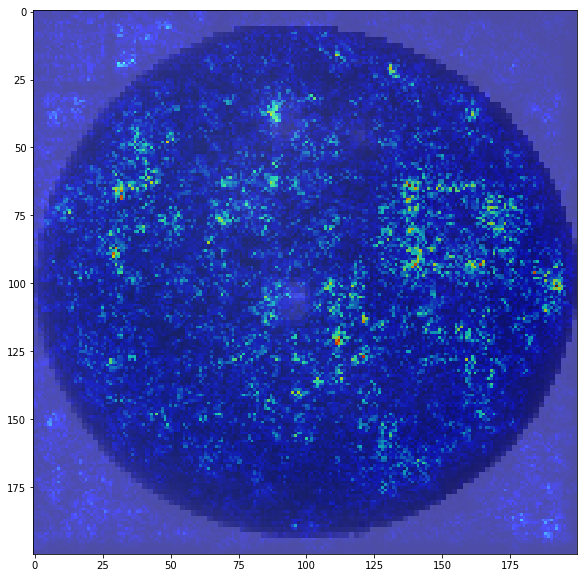

ground truth:  0.0
predict:  6.0313106e-08


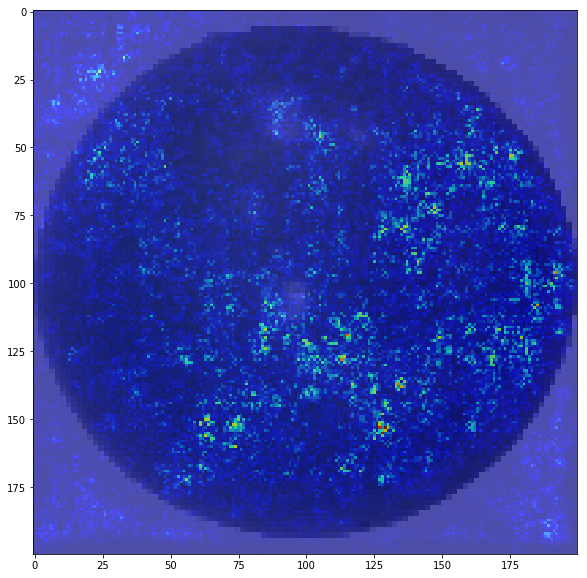

ground truth:  0.0
predict:  1.08262824e-07


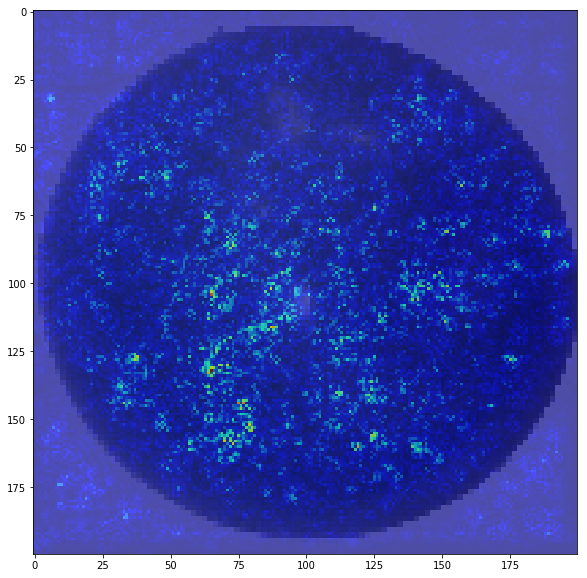

ground truth:  0.0
predict:  1.7093772e-07


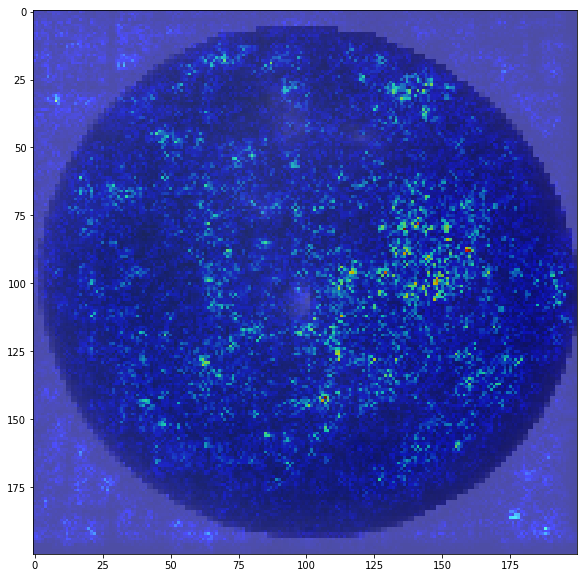

ground truth:  0.0
predict:  6.2924435e-08


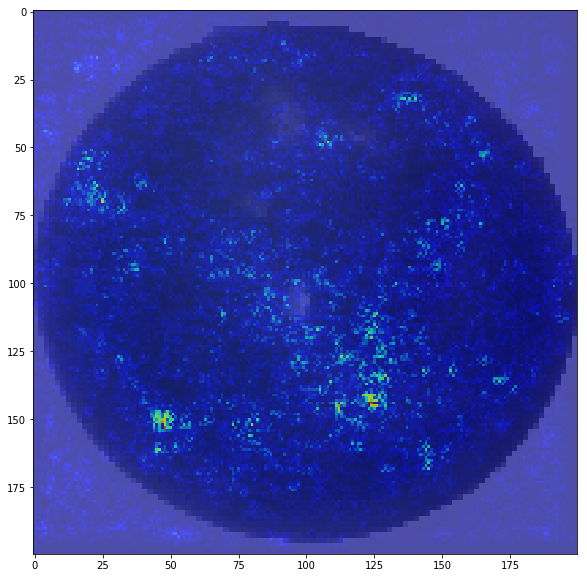

ground truth:  0.0
predict:  1.7977598e-07


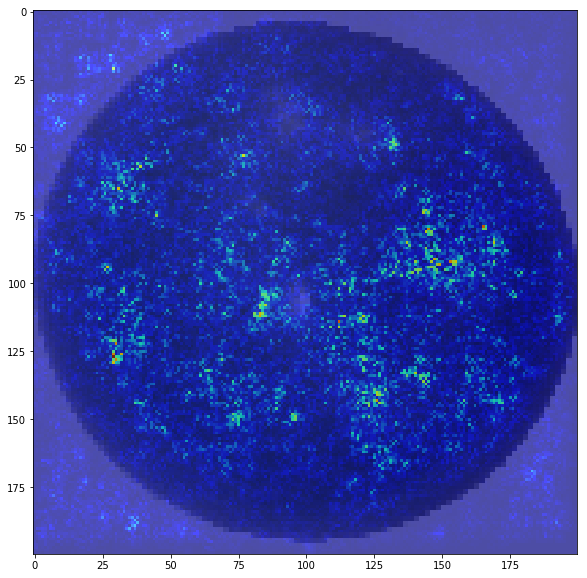

ground truth:  0.0
predict:  1.0417354e-07


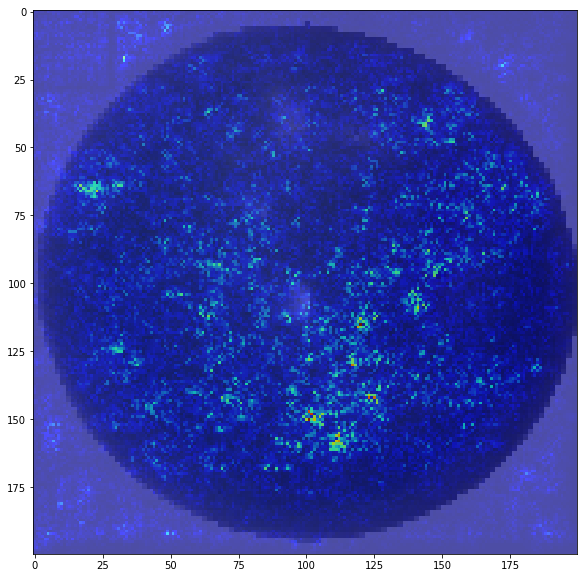

ground truth:  0.0
predict:  2.2144411e-07


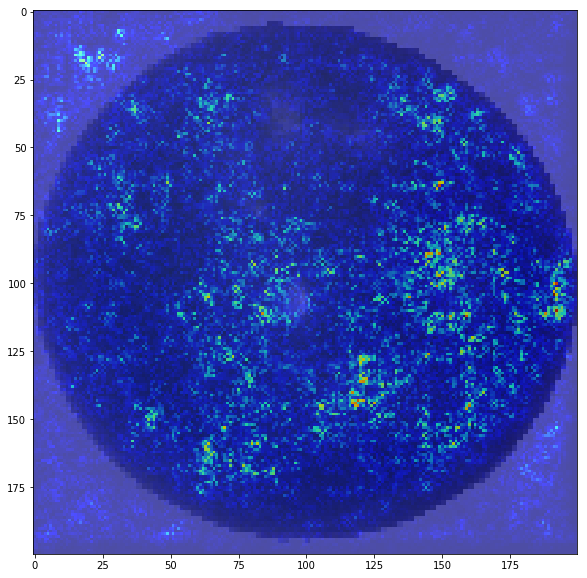

ground truth:  0.0
predict:  2.0688022e-07


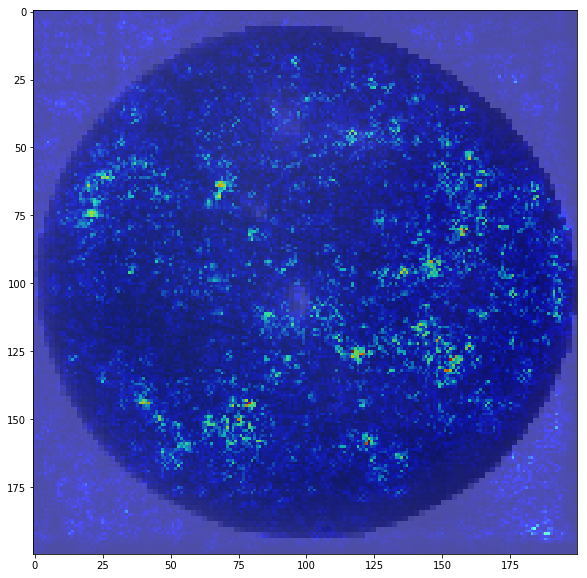

ground truth:  0.0
predict:  2.8166417e-07


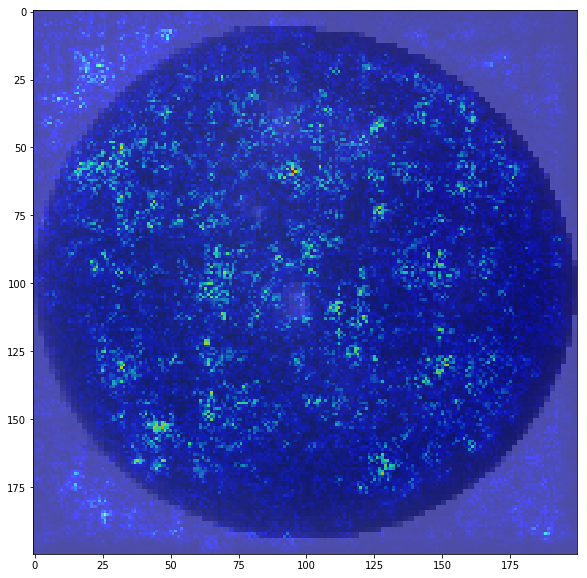

ground truth:  0.0
predict:  1.9613354e-08


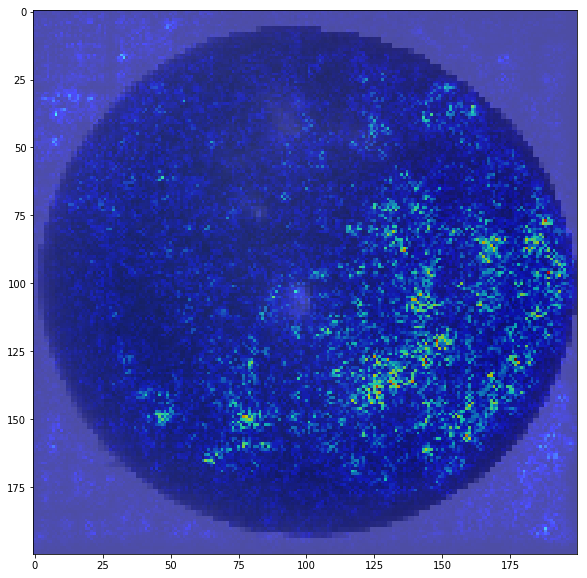

ground truth:  0.0
predict:  0.99266475


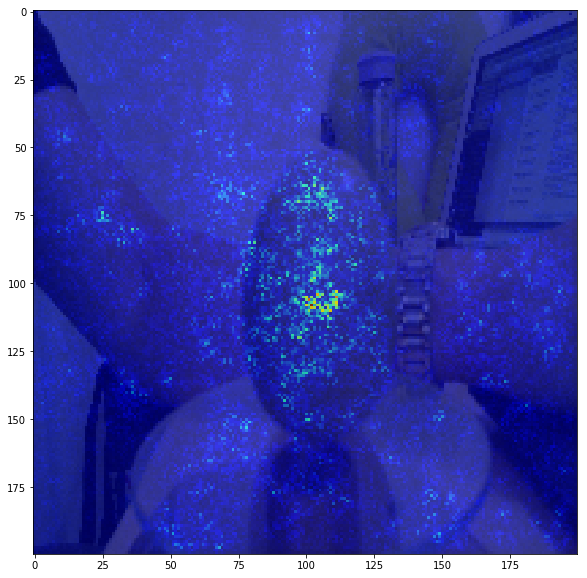

ground truth:  0.0
predict:  0.068744235


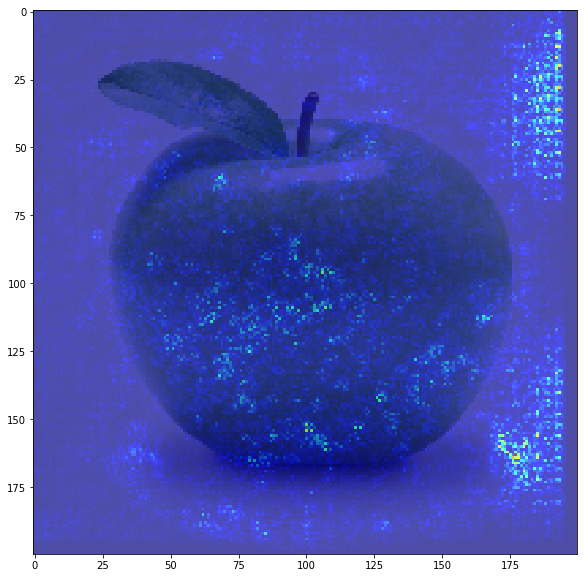

ground truth:  1.0
predict:  0.99999976


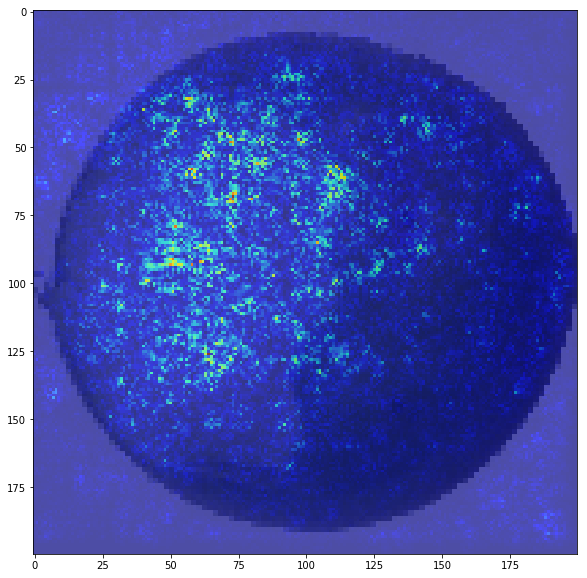

ground truth:  1.0
predict:  0.99999976


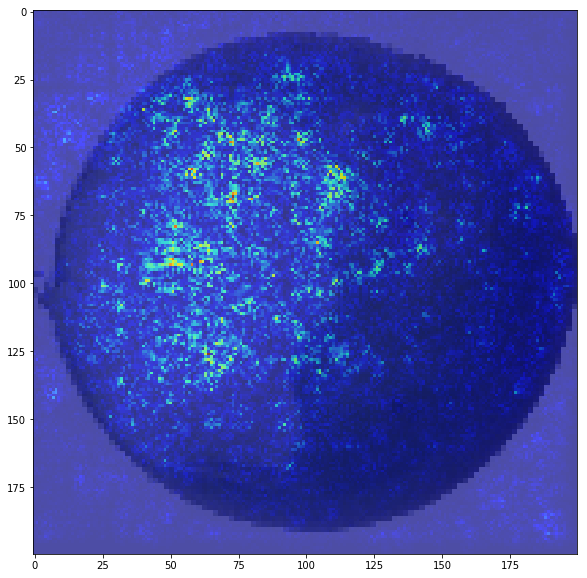

ground truth:  1.0
predict:  0.99999964


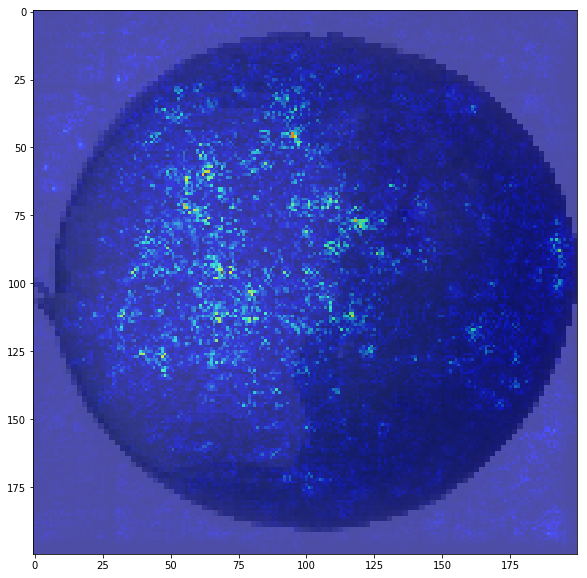

ground truth:  1.0
predict:  0.99999964


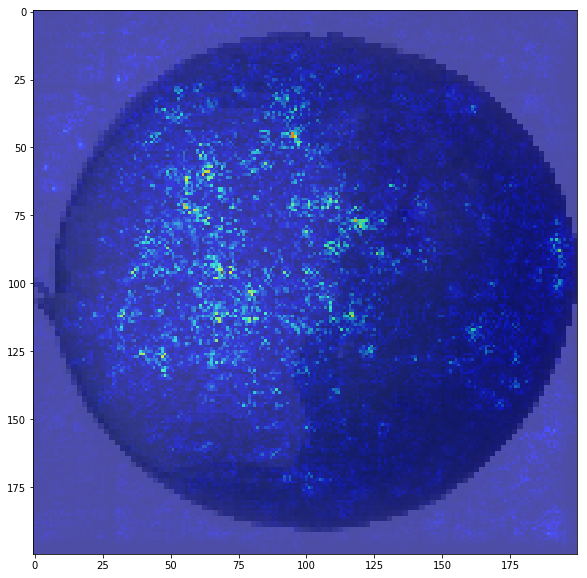

ground truth:  1.0
predict:  0.999998


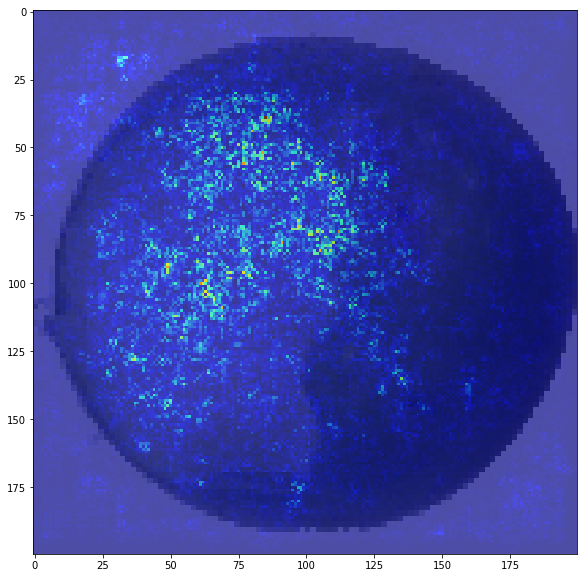

ground truth:  1.0
predict:  0.999998


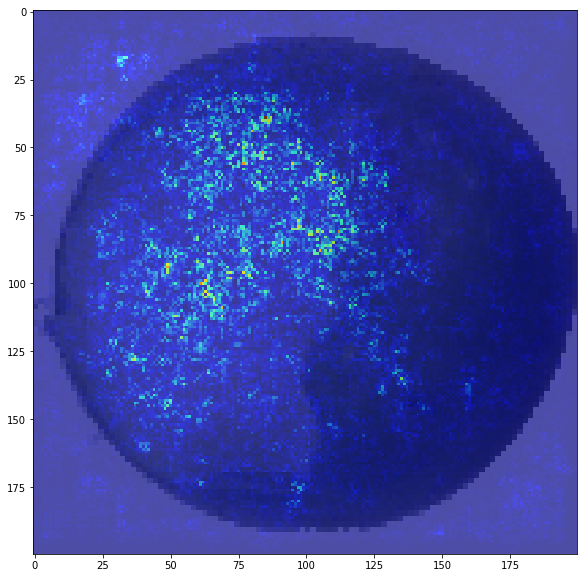

ground truth:  1.0
predict:  0.9999999


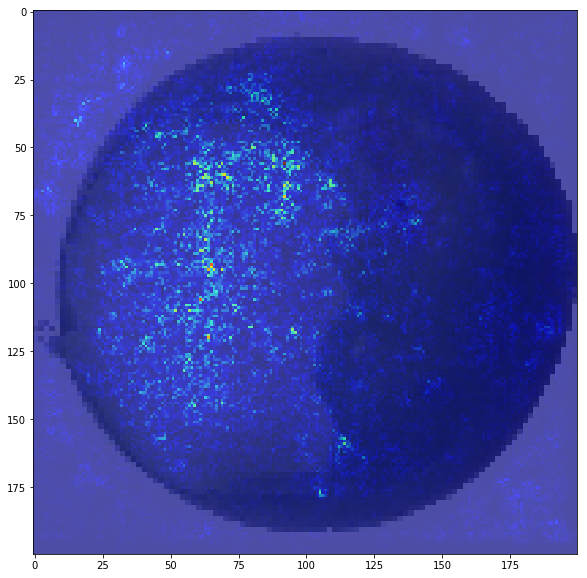

ground truth:  1.0
predict:  0.9999999


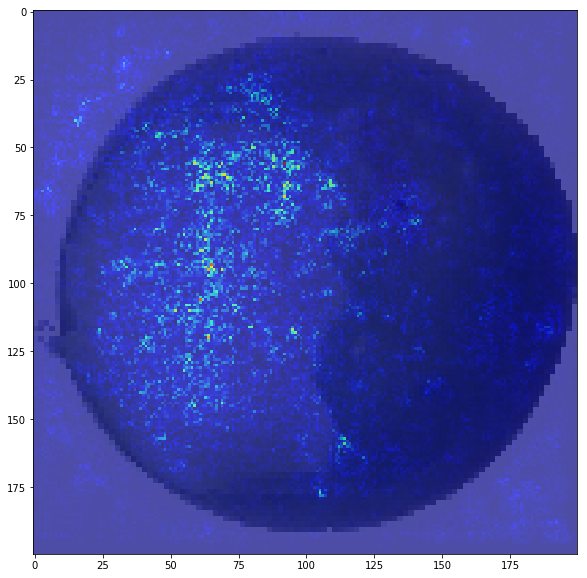

ground truth:  1.0
predict:  1.0


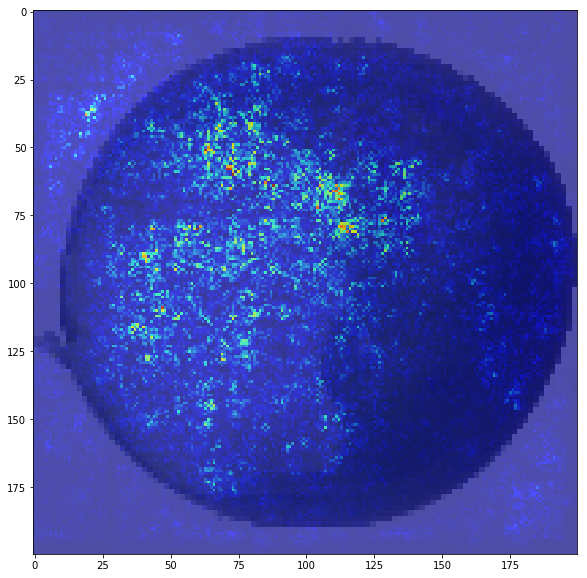

ground truth:  1.0
predict:  0.99999976


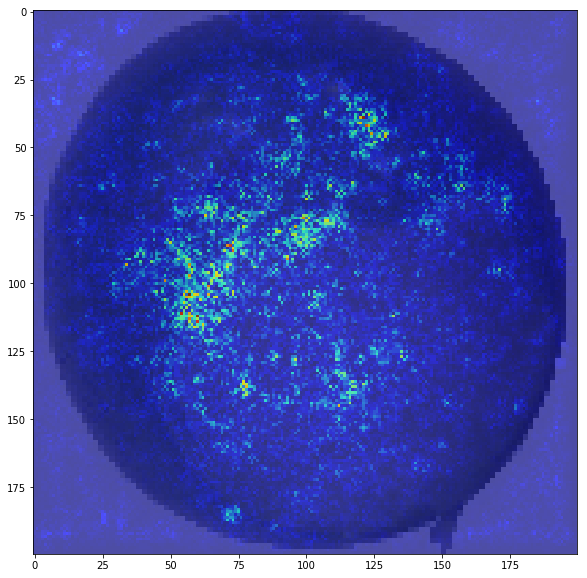

ground truth:  1.0
predict:  0.99999976


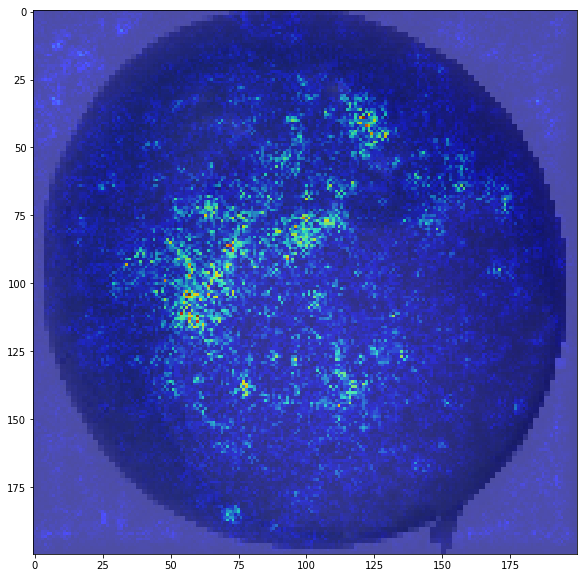

ground truth:  1.0
predict:  0.9999999


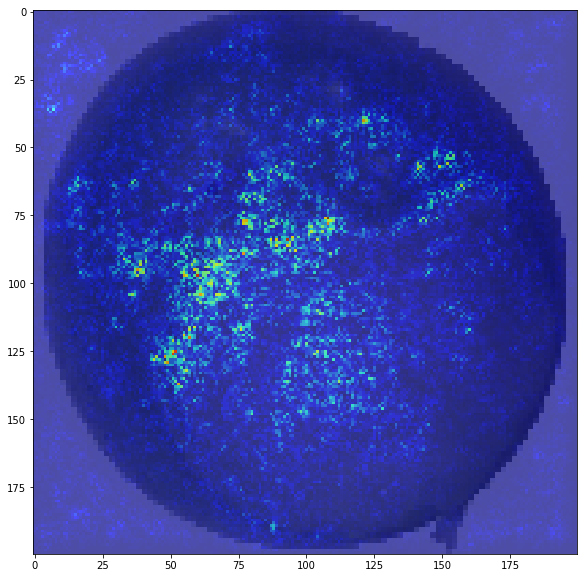

ground truth:  1.0
predict:  0.9999999


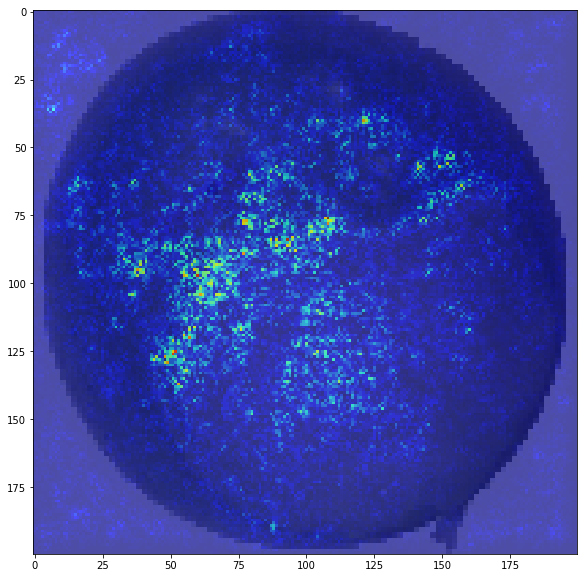

In [29]:
for n in range(X_test.shape[0]):
    plt.figure(figsize=(20,10))
    print("ground truth: ", y_test[n])
    print("predict: ", preds[n])
    grads = visualize_saliency(model, layer_idx, filter_indices=None, seed_input=X_test[n])
#     plt.subplot(1, 2, 1)
    plt.imshow(X_test[n])
    plt.imshow(grads, cmap='jet', alpha=0.7)
#     plt.subplot(1, 2, 2)
#     plt.imshow(X_test[-1 - n])
    plt.show()

In [28]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
img_path = 'server/img/ng1.jpg'


In [29]:
# img = cv2.imread(img_path)
img = Image.open(img_path)
img = img.resize((200,200))

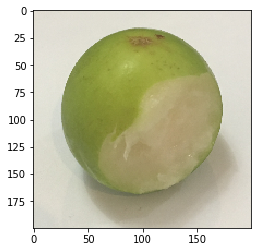

In [30]:
plt.imshow(img)

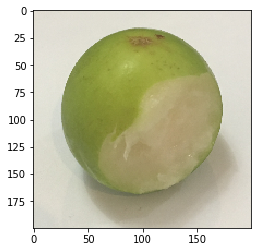

In [31]:
plt.imshow(img)

In [32]:
img = np.reshape(img,(1,200,200,3))

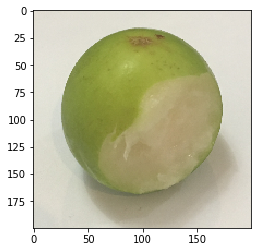

In [33]:
np.shape(img)
plt.imshow(img[0])

In [34]:
preds = model.predict(img).flatten()

In [35]:
preds

array([0.9858833], dtype=float32)